In [1]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
68*32

2176

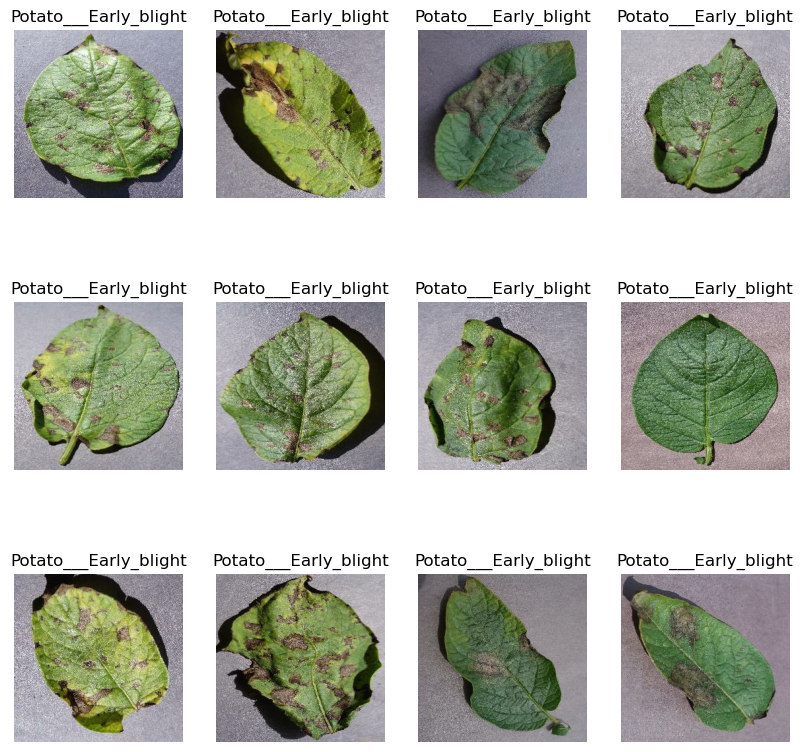

In [8]:
#RGB color codes of photographs
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")
    #print(image_batch[0].shape) #3D array


In [9]:
len(dataset) #each element is 32 batch

68

In [10]:
#80% -> trainig
#20% -> 10% validation, 10% test
#split data set according this values

In [11]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54) #arr[54:] #slicing operator at python list #skip first 54 and getting remaining 54 onwards first 54 arr[:54]
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
# We can sum all prototypes in just one function
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12) # seed can be anything
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size) # validated data set
    test_ds = ds.skip(train_size).skip(val_size) # test data set
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)
len(test_ds)

8

In [21]:
# prefetch loads next fetch on your disk, improves the performance.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #WARNING FOR TF API2
# Scale the image between 0 and 1.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
#Make picture more robust
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect')
])


In [24]:
#format of input also training starts
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
     #relu is fast # Conv layer applies 32 filters of size (3,3) to the input image. Each filter performs a convolution operation across the input image, extracting features. The activation function used here is ReLU (Rectified Linear Unit), which introduces non-linearity to the model. ReLU is a common choice as it helps in addressing the vanishing gradient problem and speeds up convergence during training.
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    #. It helps in making the model more robust to spatial translations and reducing computational complexity. Reduces dimensions
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax'), #normalize probability of the classes.
])
                          
model.build(input_shape = input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20


54/54 [==============================] - 30s 488ms/step - loss: 0.9103 - accuracy: 0.4716 - val_loss: 0.8694 - val_accuracy: 0.4479
Epoch 2/20
54/54 [==============================] - 24s 437ms/step - loss: 0.7538 - accuracy: 0.6291 - val_loss: 0.5897 - val_accuracy: 0.7188
Epoch 3/20
54/54 [==============================] - 24s 436ms/step - loss: 0.5162 - accuracy: 0.7760 - val_loss: 0.5771 - val_accuracy: 0.7240
Epoch 4/20
54/54 [==============================] - 24s 436ms/step - loss: 0.3998 - accuracy: 0.8275 - val_loss: 0.3330 - val_accuracy: 0.8646
Epoch 5/20
54/54 [==============================] - 23s 427ms/step - loss: 0.2779 - accuracy: 0.8970 - val_loss: 0.2709 - val_accuracy: 0.8906
Epoch 6/20
54/54 [==============================] - 22s 412ms/step - loss: 0.3048 - accuracy: 0.8883 - val_loss: 0.2513 - val_accuracy: 0.8750
Epoch 7/20
54/54 [==============================] - 22s 415ms/step - loss: 0.2807 - accuracy: 0.8918 - val_loss: 0.2476 - val_accuracy: 0.89

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 118ms/step - loss: 0.1131 - accuracy: 0.9688


In [29]:
scores

[0.1131133884191513, 0.96875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

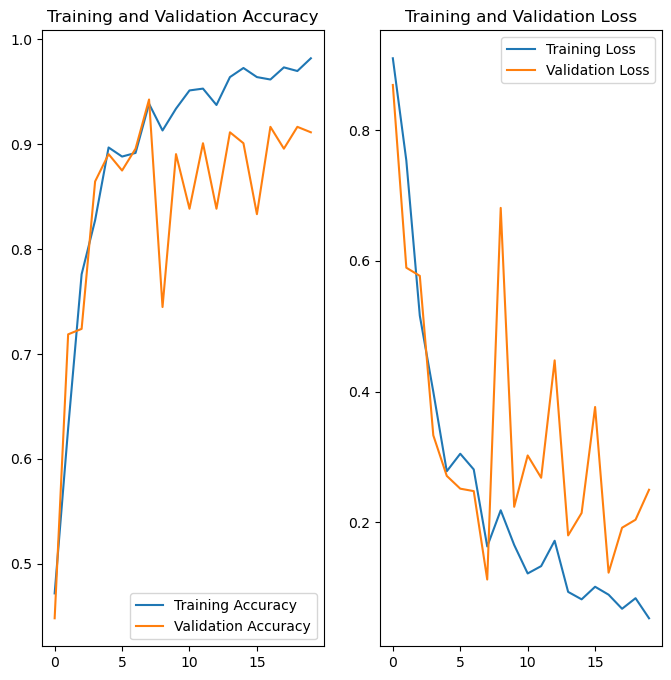

In [41]:
#Mathplotlib
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()